# functions.py

In [ ]:
import os
import numpy as np
from PIL import Image
from torch.utils import data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm


## ------------------- label conversion tools ------------------ ##
def labels2cat(label_encoder, list):
    return label_encoder.transform(list)


def labels2onehot(OneHotEncoder, label_encoder, list):
    return OneHotEncoder.transform(
        label_encoder.transform(list).reshape(-1, 1)
    ).toarray()


def onehot2labels(label_encoder, y_onehot):
    return label_encoder.inverse_transform(np.where(y_onehot == 1)[1]).tolist()


def cat2labels(label_encoder, y_cat):
    return label_encoder.inverse_transform(y_cat).tolist()


## ---------------------- Dataloaders ---------------------- ##
# for CRNN
class Dataset_CRNN(data.Dataset):
    # Pytorch의 Dataset을 상속받아 구현됨

    def __init__(self, data_path, folders, labels, frames, transform=None):
        "Initialization"
        self.data_path = data_path
        self.labels = labels
        self.folders = folders
        self.transform = transform
        self.frames = frames

    # 데이터 개수 반환
    # DataLoader가 batch를 만들 때, 전체 데이터 개수를 알 수 있도록 제공해야 함
    def __len__(self):
        "Denotes the total number of samples"
        return len(self.folders)

    # 특정 비디오 폴더에서 원하는 프레임들을 불러옴
    def read_images(self, path, selected_folder, use_transform):
        X = []

        frame_files = sorted([f for f in os.listdir(os.path.join(path, selected_folder)) if f.endswith('.jpg')])

        for i in self.frames:
          frame_filename = "frame{:06d}.jpg".format(i)  # 프레임 파일명 생성
          frame_path = os.path.join(path, selected_folder, frame_filename)

          # 파일 존재 여부 확인 (예외 처리)
          if not os.path.exists(frame_path):
            # print(f"⚠️ 프레임 {frame_path}이 존재하지 않습니다. 마지막 프레임을 사용합니다.")
            frame_path = os.path.join(path, selected_folder, frame_files[-1])  # 마지막 프레임 사용

          image = Image.open(frame_path)

          if use_transform is not None:
              image = use_transform(image)

          X.append(image)

        # 모델에 입력 가능하도록 1개의 텐서로 변환
        X = torch.stack(X, dim=0)

        return X

    def __getitem__(self, index):
        "Generates one sample of data"
        # Select sample
        folder = self.folders[index]

        # Load data
        X = self.read_images(
            self.data_path, folder, self.transform
        )  # (input) spatial images
        y = torch.LongTensor(
            [self.labels[index]]
        )  # (labels) LongTensor are for int64 instead of FloatTensor

        # print(X.shape)
        return X, y


## ---------------------- end of Dataloaders ---------------------- ##


## -------------------- (reload) model prediction ---------------------- ##

def CRNN_final_prediction(model, device, loader):
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()

    all_y_pred = []
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(tqdm(loader)):
            # distribute data to device
            X = X.to(device)
            output = rnn_decoder(cnn_encoder(X))
            y_pred = output.max(1, keepdim=True)[
                1
            ]  # location of max log-probability as prediction
            all_y_pred.extend(y_pred.cpu().data.squeeze().numpy().tolist())

    return all_y_pred


## -------------------- end of model prediction ---------------------- ##


## ------------------------ CRNN module ---------------------- ##


def conv2D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv2D
    outshape = (
        np.floor(
            (img_size[0] + 2 * padding[0] - (kernel_size[0] - 1) - 1) / stride[0] + 1
        ).astype(int),
        np.floor(
            (img_size[1] + 2 * padding[1] - (kernel_size[1] - 1) - 1) / stride[1] + 1
        ).astype(int),
    )
    return outshape


# 2D CNN encoder train from scratch (no transfer learning)
class EncoderCNN(nn.Module):
    def __init__(
        self,
        img_x=90,
        img_y=120,
        fc_hidden1=512,
        fc_hidden2=512,
        drop_p=0.3,
        CNN_embed_dim=300,
    ):
        super(EncoderCNN, self).__init__()

        self.img_x = img_x
        self.img_y = img_y
        self.CNN_embed_dim = CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 32, 64, 128, 256
        self.k1, self.k2, self.k3, self.k4 = (
            (5, 5),
            (3, 3),
            (3, 3),
            (3, 3),
        )  # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (
            (2, 2),
            (2, 2),
            (2, 2),
            (2, 2),
        )  # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (
            (0, 0),
            (0, 0),
            (0, 0),
            (0, 0),
        )  # 2d padding

        # conv2D output shapes
        self.conv1_outshape = conv2D_output_size(
            (self.img_x, self.img_y), self.pd1, self.k1, self.s1
        )  # Conv1 output shape
        self.conv2_outshape = conv2D_output_size(
            self.conv1_outshape, self.pd2, self.k2, self.s2
        )
        self.conv3_outshape = conv2D_output_size(
            self.conv2_outshape, self.pd3, self.k3, self.s3
        )
        self.conv4_outshape = conv2D_output_size(
            self.conv3_outshape, self.pd4, self.k4, self.s4
        )

        # fully connected layer hidden nodes
        self.fc_hidden1, self.fc_hidden2 = fc_hidden1, fc_hidden2
        self.drop_p = drop_p

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=self.ch1,
                kernel_size=self.k1,
                stride=self.s1,
                padding=self.pd1,
            ),
            nn.BatchNorm2d(self.ch1, momentum=0.01),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=self.ch1,
                out_channels=self.ch2,
                kernel_size=self.k2,
                stride=self.s2,
                padding=self.pd2,
            ),
            nn.BatchNorm2d(self.ch2, momentum=0.01),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=self.ch2,
                out_channels=self.ch3,
                kernel_size=self.k3,
                stride=self.s3,
                padding=self.pd3,
            ),
            nn.BatchNorm2d(self.ch3, momentum=0.01),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=self.ch3,
                out_channels=self.ch4,
                kernel_size=self.k4,
                stride=self.s4,
                padding=self.pd4,
            ),
            nn.BatchNorm2d(self.ch4, momentum=0.01),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2),
        )

        self.drop = nn.Dropout2d(self.drop_p)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(
            self.ch4 * self.conv4_outshape[0] * self.conv4_outshape[1], self.fc_hidden1
        )  # fully connected layer, output k classes
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.fc3 = nn.Linear(
            self.fc_hidden2, self.CNN_embed_dim
        )  # output = CNN embedding latent variables

    def forward(self, x_3d):
        cnn_embed_seq = []
        for t in range(x_3d.size(1)):
            # CNNs
            x = self.conv1(x_3d[:, t, :, :, :])
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            x = x.view(x.size(0), -1)  # flatten the output of conv

            # FC layers
            x = F.relu(self.fc1(x))
            # x = F.dropout(x, p=self.drop_p, training=self.training)
            x = F.relu(self.fc2(x))
            x = F.dropout(x, p=self.drop_p, training=self.training)
            x = self.fc3(x)
            cnn_embed_seq.append(x)

        # swap time and sample dim such that (sample dim, time dim, CNN latent dim)
        cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0).transpose_(0, 1)
        # cnn_embed_seq: shape=(batch, time_step, input_size)

        return cnn_embed_seq


# 2D CNN encoder using ResNet-152 pretrained
class ResCNNEncoder(nn.Module):
    def __init__(self, fc_hidden1=512, fc_hidden2=512, drop_p=0.3, CNN_embed_dim=300):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(ResCNNEncoder, self).__init__()

        self.fc_hidden1, self.fc_hidden2 = fc_hidden1, fc_hidden2
        self.drop_p = drop_p

        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]  # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, fc_hidden1)
        self.bn1 = nn.BatchNorm1d(fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(fc_hidden1, fc_hidden2)
        self.bn2 = nn.BatchNorm1d(fc_hidden2, momentum=0.01)
        self.fc3 = nn.Linear(fc_hidden2, CNN_embed_dim)

    def forward(self, x_3d):
        cnn_embed_seq = []
        for t in range(x_3d.size(1)):
            # ResNet CNN
            with torch.no_grad():
                x = self.resnet(x_3d[:, t, :, :, :])  # ResNet
                x = x.view(x.size(0), -1)  # flatten output of conv

            # FC layers
            x = self.bn1(self.fc1(x))
            x = F.relu(x)
            x = self.bn2(self.fc2(x))
            x = F.relu(x)
            x = F.dropout(x, p=self.drop_p, training=self.training)
            x = self.fc3(x)

            cnn_embed_seq.append(x)

        # swap time and sample dim such that (sample dim, time dim, CNN latent dim)
        cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0).transpose_(0, 1)
        # cnn_embed_seq: shape=(batch, time_step, input_size)

        return cnn_embed_seq


class DecoderRNN(nn.Module):
    def __init__(
        self,
        CNN_embed_dim=300,
        h_RNN_layers=3,
        h_RNN=256,
        h_FC_dim=128,
        drop_p=0.3,
        num_classes=50,
    ):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = CNN_embed_dim  # CNN에서 온 512차원 벡터 입력
        self.h_RNN_layers = h_RNN_layers  # RNN hidden layers(512)
        self.h_RNN = h_RNN
        self.h_FC_dim = h_FC_dim
        self.drop_p = drop_p
        self.num_classes = num_classes

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=h_RNN_layers,
            batch_first=True,  # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.fc1 = nn.Linear(self.h_RNN, self.h_FC_dim)
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)

    def forward(self, x_RNN):

        self.LSTM.flatten_parameters()
        RNN_out, (h_n, h_c) = self.LSTM(x_RNN, None)
        """ h_n shape (n_layers, batch, hidden_size), h_c shape (n_layers, batch, hidden_size) """
        """ None represents zero initial hidden state. RNN_out has shape=(batch, time_step, output_size) """

        # FC layers
        x = self.fc1(RNN_out[:, -1, :])  # choose RNN_out at the last time step
        x = F.relu(x)
        x = F.dropout(x, p=self.drop_p, training=self.training)
        x = self.fc2(x)

        return x


## ---------------------- end of CRNN module ---------------------- ##


## ResNetCRNN

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using 1 GPU!
Train Epoch: 1 [50/314 (16%)]	Loss: 0.767509, Accu: 50.00%
Train Epoch: 1 [100/314 (31%)]	Loss: 1.662086, Accu: 40.00%
Train Epoch: 1 [150/314 (47%)]	Loss: 0.881225, Accu: 50.00%
Train Epoch: 1 [200/314 (62%)]	Loss: 0.746402, Accu: 80.00%
Train Epoch: 1 [250/314 (78%)]	Loss: 0.865497, Accu: 50.00%
Train Epoch: 1 [300/314 (94%)]	Loss: 1.246774, Accu: 50.00%

Test set (105 samples): Average loss: 0.8676, Accuracy: 43.81%

Epoch 1 model saved!
Train Epoch: 2 [50/314 (16%)]	Loss: 1.013252, Accu: 40.00%
Train Epoch: 2 [100/314 (31%)]	Loss: 0.868578, Accu: 80.00%
Train Epoch: 2 [150/314 (47%)]	Loss: 0.769161, Accu: 70.00%
Train Epoch: 2 [200/314 (62%)]	Loss: 0.919978, Accu: 40.00%
Train Epoch: 2 [250/314 (78%)]	Loss: 1.031696, Accu: 60.00%
Train Epoch: 2 [300/314 (94%)]	Loss: 0.653806, Accu: 80.00%

Test set (105 samples): Average loss: 0.9247, Accuracy: 56.19%

Epoch 2 model saved!
Train Epoch: 3 [50/314 (16%)]	Loss: 0.586169, Accu: 80.00%
Train Epoch: 3 [100/314 (31%)]	Loss: 0

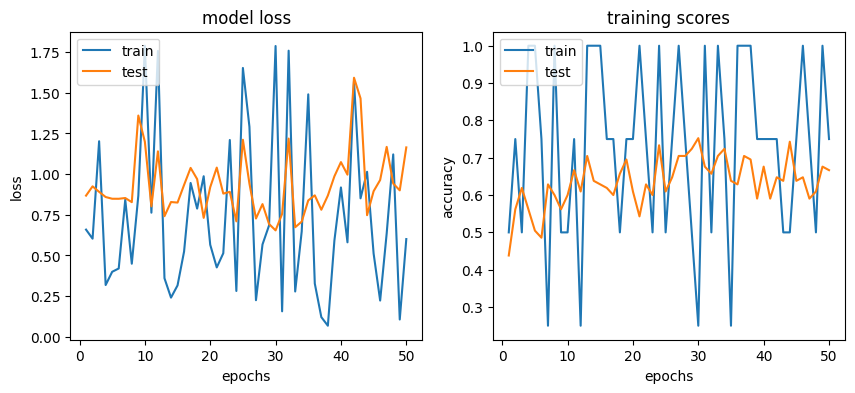

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

# 데이터 경로
data_path = "/content/drive/MyDrive/DMS/data/YawDD dataset/YawDD_frames"
save_model_path = "/content/drive/MyDrive/DMS/ResNetCRNN_test_ckpt"  # 학습된 모델 저장 경로

# CNN(ResNet) 설정
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 768  # 첫번째, 두번째 fc layer 뉴런 개수
CNN_embed_dim = 512  # 2D CNN이 추출하는 특징 벡터 크기
res_size = 224  # ResNet 이미지 크기
dropout_p = 0.0  # 드롭아웃 비율

# RNN 설정
# RNN 출력(512 차원) -> 256차원으로 변환
RNN_hidden_layers = 3  # 3-layer LSTM
# 각 time step 마다 RNN이 기억하는 상태 크기, RNN의 출력 크기도 기본적으로 512
RNN_hidden_nodes = 512
RNN_FC_dim = 256

# 학습 파라미터
k = 3  # Normal, Yawning, Talking
epochs = 50  # 총 학습 횟수
batch_size = 10
learning_rate = 1e-3
log_interval = 5  # 몇 번의 배치마다 로그를 출력할지

# 각 비디오에서 몇 개의 프레임을 사용할지 정의
begin_frame, end_frame, skip_frame = 1, 29, 1


def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.train()
    rnn_decoder.train()

    losses = []
    scores = []
    N_count = 0  # 총 학습 샘플 수
    for batch_idx, (X, y) in enumerate(train_loader):  # 배치 단위로 데이터 로드
        # distribute data to device
        X, y = X.to(device), y.to(device).view(
            -1,
        )

        N_count += X.size(0)

        optimizer.zero_grad()
        output = rnn_decoder(  # CNN + RNN 통과
            cnn_encoder(X)
        )  # output has dim = (batch, number of classes)

        loss = F.cross_entropy(output, y)  # 손실 함수 계산
        losses.append(loss.item())

        # to compute accuracy
        # torch.max() -> 샘플에서 가장 큰 점수를 가진 클래스 값과 해당 클래스 인덱스를 반환
        # 반환된 튜플에서 두번째 값(인덱스)를 선택하여, 각 샘플의 예측된 클래스 인덱스를 y_pred에 저장
        y_pred = torch.max(output, 1)[1]
        # 해당 배치에서의 정확도
        step_score = accuracy_score(
            # GPU에 있던 데이터를 GPU로 옮김
            y.cpu().data.squeeze().numpy(),
            y_pred.cpu().data.squeeze().numpy(),
        )
        scores.append(step_score)  # computed on CPU

        loss.backward()  # 역전파 수행 = 각 파라미터에 대한 기울기를 계산
        optimizer.step()  # 계산된 기울기를 기반으로 모델의 파라미터를 업데이트

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%".format(
                    epoch + 1,
                    N_count,
                    len(train_loader.dataset),
                    100.0 * (batch_idx + 1) / len(train_loader),
                    loss.item(),
                    100 * step_score,
                )
            )

    return losses, scores


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(
                -1,
            )

            output = rnn_decoder(cnn_encoder(X))

            loss = F.cross_entropy(output, y, reduction="sum")
            test_loss += loss.item()  # sum up batch loss
            y_pred = output.max(1, keepdim=True)[
                1
            ]  # (y_pred != output) get the index of the max log-probability

            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(
        all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy()
    )

    # show information
    print(
        "\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n".format(
            len(all_y), test_loss, 100 * test_score
        )
    )

    # save Pytorch models of best record
    torch.save(
        cnn_encoder.state_dict(),
        os.path.join(save_model_path, "cnn_encoder_epoch{}.pth".format(epoch + 1)),
    )  # save spatial_encoder
    torch.save(
        rnn_decoder.state_dict(),
        os.path.join(save_model_path, "rnn_decoder_epoch{}.pth".format(epoch + 1)),
    )  # save motion_encoder
    torch.save(
        optimizer.state_dict(),
        os.path.join(save_model_path, "optimizer_epoch{}.pth".format(epoch + 1)),
    )  # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return test_loss, test_score


use_cuda = torch.cuda.is_available()  # GPU 사용 여부 확인
device = torch.device("cuda" if use_cuda else "cpu")  # use CPU or GPU

# 데이터 로더 파라미터
params = (
    {
        "batch_size": batch_size,  # 한 번에 처리할 데이터 개수
        "shuffle": True,  # 데이터 섞기
        "num_workers": 2,  # 데이터를 로드하는 프로세스 개수 (병렬 처리))
        "pin_memory": True,  # CUDA 사용 시 메모리 핀 설정으로 속도 향상
    }
    if use_cuda
    else {}
)


action_names = ["Normal", "Talking", "Yawning"]

# convert labels -> category
le = LabelEncoder()
le.fit(action_names)

# show how many classes there are
list(le.classes_)

# convert category -> 1-hot
action_category = le.transform(action_names).reshape(-1, 1)
enc = OneHotEncoder()
enc.fit(action_category)

actions = []
fnames = os.listdir(data_path)
all_names = []

for f in fnames: # 예시) dash male/female, mirror male/female
    clips_dirs_path = os.path.join(data_path, f)

    for label_dir in os.listdir(clips_dirs_path):  # 예: Normal, Talking, Yawning
        clipped_dirs_path = os.path.join(clips_dirs_path, label_dir)

        for clipped_dirs in os.listdir(clipped_dirs_path):
              file_path = os.path.join(f, label_dir, clipped_dirs)
              actions.append(label_dir)  # 파일의 액션(Label) 저장
              all_names.append(file_path)  # 전체 파일 경로 저장


# list all data files
all_X_list = all_names  # all video file names
all_y_list = labels2cat(le, actions)  # all video labels

# Stratified 방식으로 데이터셋을 분할 (클래스 균형 유지)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, test_idx = next(sss.split(all_X_list, all_y_list))

train_list = [all_X_list[i] for i in train_idx]
test_list = [all_X_list[i] for i in test_idx]
train_label = [all_y_list[i] for i in train_idx]
test_label = [all_y_list[i] for i in test_idx]

# 데이터 변환
transform = transforms.Compose(
    [
        transforms.Resize([res_size, res_size]),  # 입력 이미지 크기 조정
        transforms.ToTensor(),  # 이미지를 텐서로 변환
        # ImageNet의 평균 및 표준편차를 사용하여 정규화
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# 사용할 프레임 선택
selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()

# 데이터셋 생성
train_set, valid_set = Dataset_CRNN(
    data_path, train_list, train_label, selected_frames, transform=transform
), Dataset_CRNN(data_path, test_list, test_label, selected_frames, transform=transform)

train_loader = data.DataLoader(train_set, **params)
valid_loader = data.DataLoader(valid_set, **params)


# Create model
cnn_encoder = ResCNNEncoder(
    fc_hidden1=CNN_fc_hidden1,
    fc_hidden2=CNN_fc_hidden2,
    drop_p=dropout_p,
    CNN_embed_dim=CNN_embed_dim,
).to(device)
rnn_decoder = DecoderRNN(
    CNN_embed_dim=CNN_embed_dim,
    h_RNN_layers=RNN_hidden_layers,
    h_RNN=RNN_hidden_nodes,
    h_FC_dim=RNN_FC_dim,
    drop_p=dropout_p,
    num_classes=k,
).to(device)

# Parallelize model to multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    cnn_encoder = nn.DataParallel(cnn_encoder)
    rnn_decoder = nn.DataParallel(rnn_decoder)

    # Combine all EncoderCNN + DecoderRNN parameters
    crnn_params = (
        list(cnn_encoder.module.fc1.parameters())
        + list(cnn_encoder.module.bn1.parameters())
        + list(cnn_encoder.module.fc2.parameters())
        + list(cnn_encoder.module.bn2.parameters())
        + list(cnn_encoder.module.fc3.parameters())
        + list(rnn_decoder.parameters())
    )

elif torch.cuda.device_count() == 1:
    print("Using", torch.cuda.device_count(), "GPU!")
    # Combine all EncoderCNN + DecoderRNN parameters
    crnn_params = (
        list(cnn_encoder.fc1.parameters())
        + list(cnn_encoder.bn1.parameters())
        + list(cnn_encoder.fc2.parameters())
        + list(cnn_encoder.bn2.parameters())
        + list(cnn_encoder.fc3.parameters())
        + list(rnn_decoder.parameters())
    )

optimizer = torch.optim.Adam(crnn_params, lr=learning_rate)


# 학습 및 검증 손실과 정확도를 저장할 리스트 생성
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []

# 학습 진행
for epoch in range(epochs):
    # train, test model
    train_losses, train_scores = train(
        log_interval, [cnn_encoder, rnn_decoder], device, train_loader, optimizer, epoch
    )
    epoch_test_loss, epoch_test_score = validation(
        [cnn_encoder, rnn_decoder], device, optimizer, valid_loader
    )

    # save results
    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)
    epoch_test_losses.append(epoch_test_loss)
    epoch_test_scores.append(epoch_test_score)

    # save all train test results
    A = np.array(epoch_train_losses)
    B = np.array(epoch_train_scores)
    C = np.array(epoch_test_losses)
    D = np.array(epoch_test_scores)
    np.save("./CRNN_epoch_training_losses.npy", A)
    np.save("./CRNN_epoch_training_scores.npy", B)
    np.save("./CRNN_epoch_test_loss.npy", C)
    np.save("./CRNN_epoch_test_score.npy", D)

# plot
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(1, epochs + 1), A[:, -1])  # train loss (on epoch end)
plt.plot(np.arange(1, epochs + 1), C)  #  test loss (on epoch end)
plt.title("model loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper left")
# 2nd figure
plt.subplot(122)
plt.plot(np.arange(1, epochs + 1), B[:, -1])  # train accuracy (on epoch end)
plt.plot(np.arange(1, epochs + 1), D)  #  test accuracy (on epoch end)
plt.title("training scores")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["train", "test"], loc="upper left")
title = "./fig_UCF101_ResNetCRNN.png"
plt.savefig(title, dpi=600)
# plt.close(fig)
plt.show()
